In [12]:
from __future__ import division
# import pyspark as ps    # import the spark suite
# import warnings         # display warning if spark context already exists
# import os
import pandas as pd
import numpy as np

# from pyspark.sql.functions import udf
# from pyspark.sql.types import ArrayType, StringType, FloatType
from pyspark.sql.functions import mean as sql_mean

# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import colorsys
import random

import matplotlib.pyplot as plt
% matplotlib inline

## Now that our database is saved as a parquet, we can query it directly

In [2]:
# Use formatting to set table name

table = "parquet.`data/excerpt_df.parquet`"

spark.sql('''
    SELECT author, tokenized, w2v 
    FROM {}
    LIMIT 10
    '''.format(table)).show()

+--------------+--------------------+--------------------+
|        author|           tokenized|                 w2v|
+--------------+--------------------+--------------------+
|CharlesDickens|[a, christmas, ca...|[-0.1702252033501...|
|CharlesDickens|[mind, i, dont, m...|[-0.2174013902028...|
|CharlesDickens|[scrooge, never, ...|[-0.1526826002821...|
|CharlesDickens|[nobody, ever, st...|[-0.1897002885570...|
|CharlesDickens|[the, door, of, s...|[-0.1829826451034...|
|CharlesDickens|[i, do, said, scr...|[-0.2629524400289...|
|CharlesDickens|[uncle, pleaded, ...|[-0.2502119612455...|
|CharlesDickens|[the, clerk, in, ...|[-0.2832240152638...|
|CharlesDickens|[i, am, sorry, wi...|[-0.1989532466069...|
|CharlesDickens|[mr, marley, has,...|[-0.2183633688141...|
+--------------+--------------------+--------------------+



## Create Plots of each Author's text meta data

In [8]:
# thankyou nick for the plotting code
# rework further in my own sparky style 

def make_plots(DFs, col, bins, title, colors, x_lab, authors, x_lim=None, y_lim=None):
    plt.subplots(4,4,sharex=True, sharey=True, figsize=(8,8))
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.suptitle(title, fontsize=18)
    for i, DF in enumerate(DFs):
        make_hist(DF, col, bins, colors[i], x_lim, y_lim, i, x_lab, authors[i])
    
    
def make_hist(DF, col, bins, color, x_lim, y_lim, i, x_lab, author):
    # Create pandas DF of bins and counts
    temp_df = DF.select(col).toPandas()
    plt.subplot(2,2,i+1)
    plt.hist(temp_df[col], bins, normed=1, color=color, 
             alpha=0.8, label=author)
    # Find mean sentence length
    x_val = DF.select(sql_mean(col)).select('avg('+col+')').head()[0]
    plt.axvline(x=x_val, color=color, label="Mean")
    plt.xlabel(x_lab)
    plt.ylabel("Frequency")
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.legend();

In [9]:
def metadata_df(author):
    author = "'" + author + "'"
    return spark.sql('''
        SELECT char_count, avg_wordlen, word_count, sent_length 
        FROM {} 
        WHERE author = {} AND sent_length <=100
        '''.format(table, author))



twaindf = metadata_df('MarkTwain')
muirdf = metadata_df('JohnMuir')
austendf = metadata_df('JaneAusten')
dickensdf = metadata_df('CharlesDickens')


In [10]:
twaindf.show(5)

+----------+-----------+----------+-----------+
|char_count|avg_wordlen|word_count|sent_length|
+----------+-----------+----------+-----------+
|    1275.0|   4.425532|     235.0|  39.166668|
|    1529.0|   4.687732|     269.0|       27.3|
|    3034.0|   4.188034|     585.0|  27.857143|
|    1574.0|  3.9684544|     317.0|  28.818182|
|    1211.0|   4.454955|     222.0|  20.181818|
+----------+-----------+----------+-----------+
only showing top 5 rows



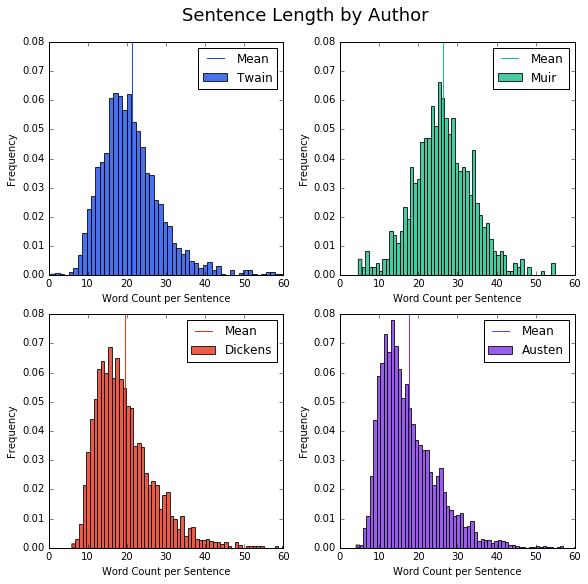

In [14]:
DFs = [twaindf, muirdf, austendf, dickensdf]
authors = ["Twain", "Muir", "Dickens", "Austen"]
colors = [[0.1, 0.3, .9], [0.1, 0.75, 0.55], [0.9, 0.2, 0.1], [0.5, 0.2, 0.9]]

# Make Sentence Length Histograms
make_plots(DFs=DFs, col='sent_length', bins=75, title='Sentence Length by Author',
           colors=colors, x_lim=(0,60), y_lim=(0, 0.08), x_lab="Word Count per Sentence", authors=authors)
plt.savefig('data/images/sent_len.png', bbox_inches='tight')

## Build Word Clouds:

In [ ]:
def get_all_text(author, table="parquet.`data/excerpt_df.parquet`"):
    author = "'" + author + "'"  
    excerpts = spark.sql('''
        SELECT excerpt
        FROM {}
        WHERE author = {}
        '''.format(table, author))

    return 





In [18]:
excerpts = spark.sql('''
    SELECT excerpt
    FROM {}
    WHERE author = {}
    '''.format(table, "'MarkTwain'"))

alltext = ' '.join([str(e) for e in excerpts.excerpt])

TypeError: Column is not iterable

In [17]:
print alltext[:5000]

Column<excerpt>
